# Chapter 13 - Tectonic-scale models and modelling tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve, brentq
from scipy.special import lambertw, erf
from scipy.integrate import odeint, quad, cumtrapz

## Corner-flow with magmatic segregation

This simplified problem is governed by the system

\begin{align}
    \label{eq:cornerflow-twophase-stokes}
    \Grad\pres = \delsq\vel \\
    \Div\vel = 0
\end{align}

and

\begin{equation*}
\vel\liq = \vel - \frac{1}{\velratio}\left(\Grad\pres + \unit{\gravity}\right)
\end{equation*}

The nondimensional solution to \eqref{eq:cornerflow-twophase-stokes} is

\begin{align}
    f(\theta) &= A\sin\theta -B\theta\cos\theta, \\
    \vel &= \left[f'(\theta)\rhat - f(\theta)\thetahat\right], \\
    \pres &= -\frac{1}{r}\left[f'''(\theta) + f'(\theta)\right] = -\frac{2B}{r}\cos\theta,
\end{align}

where

\begin{equation*}
  A = \frac{2\sin^2\theta_p}{\pi - 2\theta_p-\sin2\theta_2}
  \text{ and }
  B = \frac{2}{\pi - 2\theta_p-\sin2\theta_2}.
\end{equation*}

Recall that $\theta_p$ is the angle beneath the horizontal made by the base of the rigid wedge that represents the lithosphere.  Using the cylindrical coordinate system,

\begin{align}
  \unit{\gravity} &= \cos\theta\rhat - \sin\theta\thetahat,\\
  \Grad\pres &= \pdiff{\pres}{r}\rhat + \frac{1}{r}\pdiff{\pres}{\theta}\thetahat.
\end{align}

The liquid velocity is then

\begin{equation}
  \label{eq:cornerflow-liquid-velocity}
  \vel\liq = \left(f'(\theta)\rhat - f(\theta)\thetahat\right) -
  \frac{1}{\velratio}\left\{\frac{1}{r^2}\left[\left(f''' +f'\right)\rhat - \left(f'''' + f''\right)\thetahat\right]
    + \cos\theta\rhat + \sin\theta\thetahat\right\}.
\end{equation}

The radial and tangential components of the solid and liquid velocities are implemented as:

In [2]:
def vel_solid_radial(alph, theta):
    return -(2.*np.sin(alph)**2 * np.cos(theta) - 2.*np.cos(theta) 
             + 2.*theta*np.sin(theta))/(2.*alph - np.pi + np.sin(2.*alph))

def vel_solid_tangential(alph, theta):
    return (2.*np.sin(alph)**2 * np.sin(theta) - 2.*theta*np.cos(theta))/(2.*alph - np.pi + np.sin(2.*alph))

def vel_liquid_radial(alph, theta, r, e):
    sin_a = np.sin(alph)
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    numer = 2.*sin_a**2 * cos_t - 2.*cos_t + 2.*theta*sin_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return -numer/denom - (cos_t - ((numer/denom - (2.*sin_a**2 * cos_t - 6.*cos_t + 2.*theta*sin_t)/denom))/r**2)/e

def vel_liquid_tangential(alph, theta, r, e):
    sin_t = np.sin(theta)
    sin_a = np.sin(alph)
    cos_t = np.cos(theta)
    numer = -2.*sin_a**2 * sin_t + 2.*theta*cos_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return (sin_t - ((4.*sin_t + numer)/denom - (8.*sin_t + numer)/denom)/r**2)/e - numer/denom

Figures below plot the streamlines of the solid (4) and liquid \eqref{eq:cornerflow-liquid-velocity} velocities for the corner flow solution with uniform viscosity and porosity. The domain has a fixed size in dimensional units. The top row of panels has a larger lithospheric wedge angle $(\theta_p=30^\circ)$ than the bottom row $(\theta_p=15^\circ)$.  The left column has 100$\times$ slower melt segregation ($\velratio=1$) than the right column ($\velratio=0.01$).

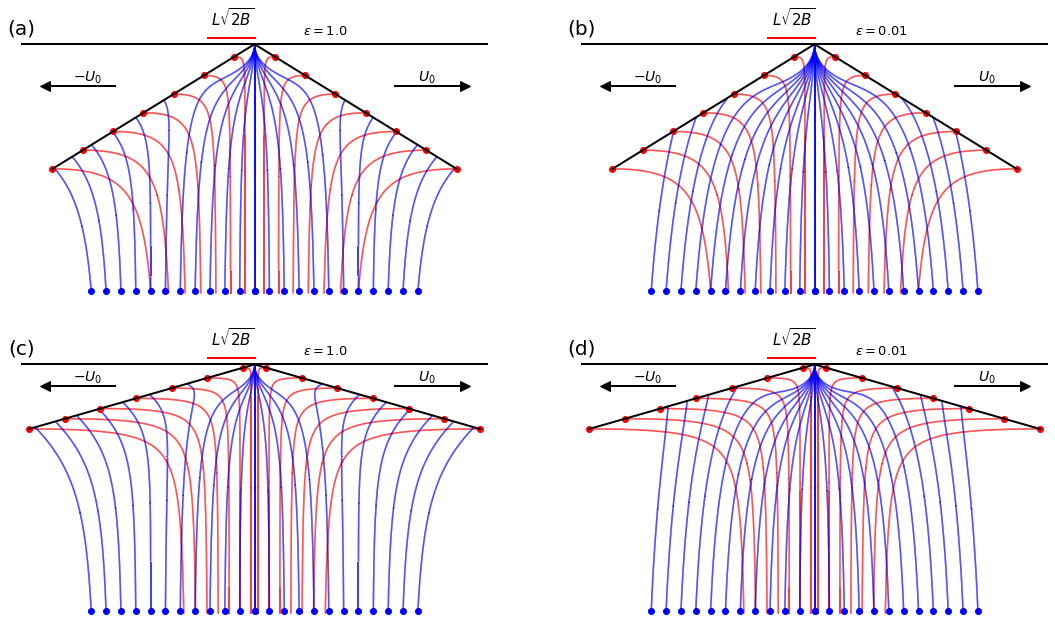

In [19]:
f, ax = plt.subplots(2, 2)
zoom = 2.0
f.set_size_inches(9.2 * zoom, 5.4 * zoom)
f.set_facecolor('w')

Ny = 500
aspect = 2.0
Nx = int(np.round(Ny*aspect))
x = np.linspace(-0.5*aspect, 0.5*aspect, Nx)
y = np.linspace(0.0, 1.0, Ny)
X, Y = np.meshgrid(x, y)
theta = -np.arctan2(Y, X) + 0.5*np.pi

seedVS = np.zeros([7, 2])
seedVL = np.zeros([12, 2])

L = 0.2
evec = np.asarray([1, 0.01])
alphvec = np.asarray([30*np.pi/180., 15*np.pi/180.])
r = np.sqrt(X**2 + Y**2)/L

annotations = [['(a)', '(b)'], ['(c)', '(d)']]

for i, alph in enumerate(alphvec):
    B = 2./(np.pi - 2*alph - np.sin(2.*alph))
    inplates = np.fabs(theta) > (0.5 * np.pi - alph)
    Lf = L * np.sqrt(2*B)
    for j, e in enumerate(evec):
        VSR = vel_solid_radial(alph, theta)
        VST = vel_solid_tangential(alph, theta)
        VLR = vel_liquid_radial(alph, theta, r, e)
        VLT = vel_liquid_tangential(alph, theta, r, e)
        VSX = VSR * np.sin(theta) + VST * np.cos(theta)
        VSY = VSR * np.cos(theta) - VST * np.sin(theta)
        VLX = VLR * np.sin(theta) + VLT * np.cos(theta)
        VLY = VLR * np.cos(theta) - VLT * np.sin(theta)            
        VLX[inplates] = np.NaN
        VLY[inplates] = np.NaN

        sm = 0.2 * np.minimum(np.sin(alph), np.cos(alph))
        
        # -----------------
        # solid streamlines
        # -----------------
        # in the positive X axis
        seedVS[:, 0] = np.linspace(sm*np.cos(alph), np.cos(alph), 7)
        seedVS[:, 1] = np.linspace(sm*np.sin(alph), np.sin(alph), 7)
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVS, color='r', maxlength=10.0, density=(100,100),
                            integration_direction='backward', minlength=0.5, arrowstyle='-')
        # in the negative X axis
        seedVS[:, 0] = np.linspace(-np.cos(alph), -sm*np.cos(alph), 7)
        seedVS[:, 1] = np.flip(np.linspace(sm*np.sin(alph), np.sin(alph), 7))
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVS, color='r', maxlength=10.0, density=(100,100),
                            integration_direction='backward', minlength=0.5, arrowstyle='-')
        
        # ------------------
        # liquid streamlines
        # ------------------
        # in the positive X axis
        seedVL[:, 0] = 0.7 * np.linspace(0.0, np.amax(x), 12)
        seedVL[:, 1] = 0.99
        ax[i, j].plot(seedVL[:, 0], seedVL[:, 1], 'bo')
        ax[i, j].streamplot(X, Y, VLX, VLY, start_points=seedVL, color='b', maxlength=10.0, density=(100,100),
                            integration_direction='forward', minlength=0.5, arrowstyle='-')
        # in the negative X axis
        seedVL[:, 0] = 0.7 * np.linspace(-np.amax(x), 0.0, 12)
        seedVL[:, 1] = 0.99
        ax[i, j].plot(seedVL[:, 0], seedVL[:, 1], 'bo')
        ax[i, j].streamplot(X, Y, VLX, VLY, start_points=seedVL, color='b', maxlength=10.0, density=(100,100),
                            integration_direction='forward', minlength=0.5, arrowstyle='-')

        ax[i, j].text(-0.47*aspect, -0.1, annotations[i][j], fontsize=20, verticalalignment='top', horizontalalignment='right')
        ax[i, j].text(0.0, -0.15, r'$L \sqrt{2B}$', fontsize=15, verticalalignment='top', horizontalalignment='right')
        ax[i, j].plot([-0.1*aspect, 0.0], [-0.025, -0.025], '-r', linewidth=2)
        ax[i, j].text(0.2*aspect, -0.08, r'$\epsilon={}$'.format(e), fontsize=13, verticalalignment='top', horizontalalignment='right')
        
        # annotations
        ax[i, j].plot([-1., 1.], [0., 0.], '-k', linewidth=2)
        ax[i, j].plot([-np.cos(alph), 0., np.cos(alph)], [np.sin(alph), 0., np.sin(alph)], '-k', linewidth=2)
        # U_0 line
        ax[i, j].plot([0.6, 0.9], [np.sin(alph)/3., np.sin(alph)/3.], '-k', linewidth=2)
        ax[i, j].plot(0.9, np.sin(alph)/3., '>k', markersize=10, markerfacecolor='k')
        ax[i, j].annotate(r'$U_0$', xy=[0.7, np.sin(alph)/3.0], fontsize=14, verticalalignment='bottom')
        # -U_0 line
        ax[i, j].plot([-0.6, -0.9], [np.sin(alph)/3., np.sin(alph)/3.], '-k', linewidth=2)
        ax[i, j].plot(-0.9, np.sin(alph)/3., '<k', markersize=10, markerfacecolor='k')
        ax[i, j].annotate(r'$-U_0$', xy=[-0.65, np.sin(alph)/3.0], fontsize=14, verticalalignment='bottom', 
                          horizontalalignment='right')
        # axes
        ax[i, j].set_xlim(-0.5*aspect, 0.5*aspect)
        ax[i, j].set_ylim(-0.05, 1.02)
        ax[i, j].set_axis_off()
        ax[i, j].invert_yaxis()

## Melt focusing through a sub-lithospheric channel

### Lateral transport in semi-infinite half-space

A measure of the efficiency of focusing is the lateral flux enhancement compared to the vertical flux far from the barrier, $q_\infty\cos\alpha$.  This efficiency be written as

\begin{align}
  \label{eq:decmp_focus_efficiency}
  \efocus &\equiv \tan\alpha\int_{-\infty}^0\left[
    \frac{R^2G''(\zeta)-G(\zeta)}{1-R^2G''(\zeta)}\right]\infd \zeta,
\end{align}

Another measure of focusing efficiency is the lateral distance traveled by melt as it traverses the full height of the domain, before freezing:

\begin{align}
  \label{eq:decmp_chan_distance_final}
  \xfocus &= \freezelength\tan\alpha \int_{-\infty}^0 \frac{R^2G''(\zeta)}{1-R^2G''(\zeta)} \infd \zeta.
\end{align}

In [8]:
def integrand(zeta, Rsquared):
    G   = (zeta + np.log(2.0) + np.log(np.cosh(zeta)))/np.log(2.0)
    # Gpp = np.sech(zeta)**2/np.log(2.0)  Numpy has no sech.
    Gpp = 1./(np.cosh(zeta)**2 * np.log(2.0))
    return (Rsquared*Gpp - G)/(1-Rsquared*Gpp)

def integrand_Dx(zeta, Rsquared):
    G   = (zeta + np.log(2.0) + np.log(np.cosh(zeta)))/np.log(2.0)
    # Gpp = np.sech(zeta)**2/np.log(2.0)  Numpy has no sech.
    Gpp = 1./(np.cosh(zeta)**2 * np.log(2.0))
    return Rsquared*Gpp/(1-Rsquared*Gpp)

Figure below plot the metrics of focusing through an inclined decompaction channel atop a semi-infinite half space.  __(a)__ Focusing efficiency calculated according to eqn. \eqref{eq:decmp_focus_efficiency}. __(b)__ Focusing distance calculated according to eqn. \eqref{eq:decmp_chan_distance_final}, normalised by $\freezelength$.

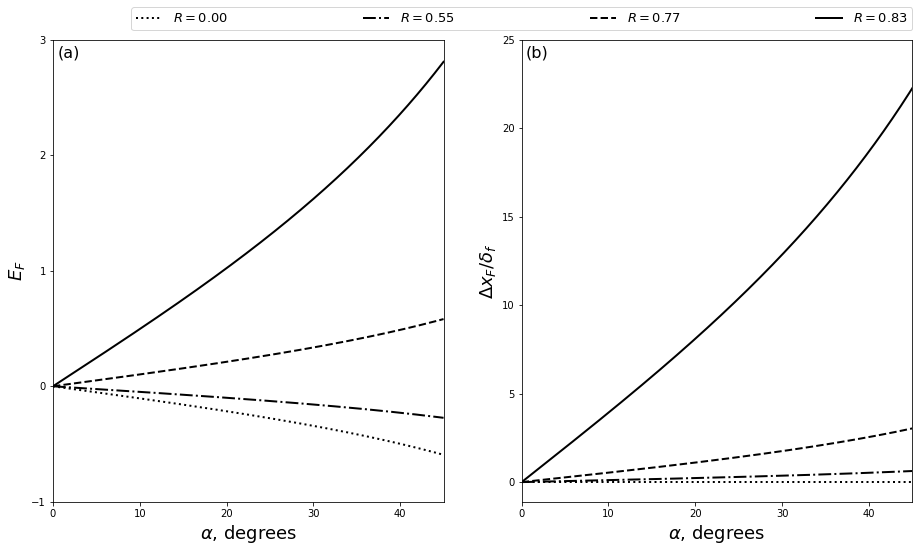

In [9]:
f, ax = plt.subplots(1, 2)
zoom = 2.0
f.set_size_inches(7.7 * zoom, 4.25 * zoom)
f.set_facecolor('w')

eps = 1.1920929e-07  # extracted from np.finfo(np.float32)
R2 = np.asarray([0.0, 0.3, 0.6, 0.69])
amax = 45.0 * np.pi/180.0
alpha = np.linspace(0.0, amax, 1000)
zeta = np.linspace(-10.0, -eps, 1000)
n = 3
plot_style = [':k', '-.k', '--k', '-k']
plots = []
labels = []

for Rsquared, pltsty in zip(R2, plot_style):
    integ = lambda z: integrand(z, Rsquared)
    ExFlx = quad(integ, -100, 0.0)
    p = ax[0].plot(alpha*180.0/np.pi, np.tan(alpha)*ExFlx[0], pltsty, linewidth=2)
    plots.append(p[0])
    labels.append('$R={:1.2f}$'.format(np.sqrt(Rsquared)))

ax[0].set_xlim(0.0, amax*180/np.pi)
ax[0].set_xticks((0, 10, 20, 30, 40))
ax[0].set_yticks((-1, 0, 1, 2, 3))
ax[0].set_xlabel(r'$\alpha$, degrees', fontsize=18)
ax[0].set_ylabel(r'$E_F$', fontsize=18)
ax[0].text(0.5, 2.95, '(a)', fontsize=16, verticalalignment='top', horizontalalignment='left')

for Rsquared, pltsty in zip(R2, plot_style):
    integ_dx = lambda z: integrand_Dx(z, Rsquared)
    ExDlx = quad(integ_dx, -100, eps)
    ax[1].plot(alpha*180.0/np.pi, np.tan(alpha)*ExDlx[0], pltsty, linewidth=2)

ax[1].set_xlim(0.0, amax*180/np.pi)
ax[1].set_xticks((0, 10, 20, 30, 40))
ax[1].set_yticks((0, 5, 10, 15, 20, 25))
ax[1].set_xlabel(r'$\alpha$, degrees', fontsize=18)
ax[1].set_ylabel(r'$\Delta x_F/\delta_f$', fontsize=18)
ax[1].text(0.5, 24.7, '(b)', fontsize=16, verticalalignment='top', horizontalalignment='left')

plt.legend(handles=plots, fontsize=13, labels=labels,
           bbox_to_anchor=(-1.0, 1.02, 2., .2),  loc='lower left', ncol=4, mode="expand", borderaxespad=0.)

plt.show()

### Lateral transport to a mid-ocean ridge

Temperature outside the partially molten region is assumed to satisfy the _half-space cooling model_ , which is assumed a steady state thermal structure determined by the balance of uniform, horizontal advection at speed $U_0$ and vertical diffusion with diffusivity $\kappa$,
\begin{equation}
  \label{eq:half-space-temperature}
  \temp_{HS}(x,z) = \temp_\text{sfc} + \left(\temp_\text{m} -
    \temp_\text{sfc}\right)\text{erf}\left(\frac{-z}{2\sqrt{\kappa x/U_0}}\right),
\end{equation}
where $\temp_\text{sfc}<\temp_\text{m}$ are the imposed surface and deep mantle temperature, respectively (we neglect the adiabatic thermal gradient); $\text{erf()}$ is the error function.

In [10]:
def half_space_cooling_temperature(distance, depth, par):
    arg = depth/(2.0*np.sqrt(par.kappa*(distance+par.x0)/par.U0))
    T_hs = par.Tsfc + (par.Tm - par.Tsfc) * erf(arg)
    return T_hs

For simplicity, we consider a one-chemical-component system. Then the solidus temperature depends on pressure only.  We take this pressure to be lithostatic and hence write the solidus temperature as
\begin{equation}
  \label{eq:mor-decomp-solidus}
  \soltemp = \soltemp_0 - \frac{\density g z}{\clapeyron}.
\end{equation}

In [11]:
def melting_temperature(depth, par):
    TS = par.TS0 + par.rho * par.g * depth / par.clapeyron
    return TS

def find_solidus_depth(depth, distance, par):
    T_hs = half_space_cooling_temperature(distance, depth, par)
    TS = melting_temperature(depth, par)
    return T_hs - TS

In [12]:
def melting_region_top_bottom(distance, par):
    depth = np.linspace(0, 100e3, 200)
    pm = (find_solidus_depth(depth, distance, par) >= 0).astype(int)
    idx = np.nonzero(np.fabs(pm[1:] - pm[0:-1]))
    depth = depth[idx + np.ones_like(idx)].flatten()
    hh0, hh1 = np.nan, np.nan
    if depth.shape[0] == 2:
        hh0 = fsolve(lambda d: find_solidus_depth(d, distance, par), depth[0])[0]
        hh1 = brentq(lambda d: find_solidus_depth(d, distance, par), depth[0] + 1.0, depth[1] + 1.0)
    return [hh0, hh1]

Figure below plots a schematic cross-sectional diagram of the model of mid-ocean ridge melt focusing. The ridge axis is located at $x=0,z=0$. The problem is assumed to have reflection symmetry about the $z$ axis. __(a)__ Temperature contours in the lithosphere (dashed); Solidus contour (i.e., where $T=\soltemp$). The partially molten region is labelled $\meltregion$. Distances $x$ are offset by 5 km to avoid an infinite thermal gradient at the origin. __(b)__ Expanded view of the boundary between the asthensphere and the lithosphere along which melt is focused in the decompaction channel. A control volume along the boundary is associated with a melting column and a lithospheric strip.

In [13]:
class PAR:
    def __init__(self):
        self.Tsfc = 273  # K
        self.Tm = 1350 + 273  # K 
        self.TS0 = 1100 + 273  # K
        self.clapeyron = 6.5e6  # Pa/K
        self.rho = 3300  # kg/m3
        self.kappa = 1e-6  # m2/sec (thermal diffusivity)
        self.g = 10  # m/sec2
        self.x0 = 5000  # m
        self.U0 = 4/100/1e7/np.pi  # m/sec

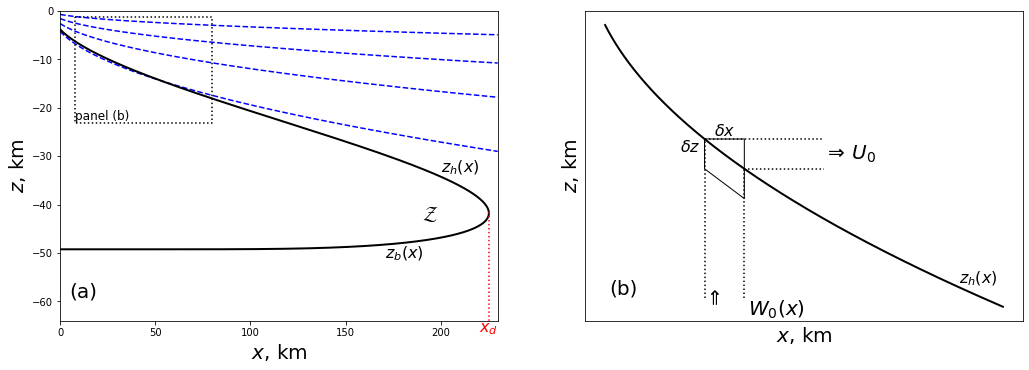

In [14]:
f, ax = plt.subplots(1, 2)
zoom = 1.5
f.set_size_inches(11.5 * zoom, 3.8 * zoom)
f.set_facecolor('w')

p = PAR()
dist = np.linspace(0, 400e3, 5000)
HH = np.asarray([melting_region_top_bottom(d, p) for d in dist])
h = HH[:, 0].flatten()
hb = HH[:, 1].flatten()

zh = np.concatenate((h[~np.isnan(h)], np.flip(hb[~np.isnan(hb)])), axis=0) / 1e3
xh = np.concatenate((dist[~np.isnan(h)], np.flip(dist[~np.isnan(hb)])), axis=0) / 1e3
ax[0].plot(xh, -zh, '-k', linewidth=2)
ax[0].set_xlim(0.0, 230.0)
ax[0].set_ylim(-np.amax(zh)*1.3, 0.0)

xd = dist[np.argmax(h[~np.isnan(h)])] / 1e3
zd = h[np.argmax(h[~np.isnan(h)])] / 1e3
ax[0].plot([xd, xd], [-zd, -zd*100], ':r')
ax[0].text(xd, -np.amax(zh)*1.3, r'$x_d$', color='r', verticalalignment='top', 
           horizontalalignment='center', fontsize=16)

[X, Z] = np.meshgrid(np.linspace(0, 230, 200), np.linspace(-50, 0, 100))
T = half_space_cooling_temperature(X*1e3, Z*1e3, p)
cc = ax[0].contour(X[0, :], Z[:, 0], T, 4, colors='b', linestyles='--')

ax[0].set_xlabel(r'$x$, km', fontsize=20)
ax[0].set_ylabel(r'$z$, km', fontsize=20)
ax[0].text(5.0, -60.0, '(a)', verticalalignment='bottom', horizontalalignment='left', fontsize=20)

i0, i1 = 100, 1000
xa, xb = xh[i0], xh[i1]
za, zb = zh[i0]-5, zh[i1]+5
ax[0].plot([xa, xb, xb, xa, xa], [-za, -za, -zb, -zb, -za],':k')
ax[0].text(xa, -zb, 'panel (b)', fontsize=12, horizontalalignment='left', verticalalignment='bottom')
ax[0].text(xh[2500], -zh[2500], r'$z_h(x)$', verticalalignment='bottom', horizontalalignment='left', fontsize=16)
ax[0].text(xh[3500], -zh[3500], r'$z_b(x)$', verticalalignment='top', horizontalalignment='left', fontsize=16)
ax[0].text(190, -42, r'$\mathcal{Z}$', verticalalignment='center', horizontalalignment='left', fontsize=20)

x = np.linspace(0, 1, 1000)
dx = 0.05
z = -np.sqrt(x + dx)
ax[1].plot(x, z,'-k', linewidth=2)

zb = 1.0
x0 = 0.25
z0 = -np.sqrt(x0+dx)
ax[1].plot([x0, x0], [-zb, z0], ':k')
x1 = x0 + 0.1
z1 = -np.sqrt(x1+dx)
ax[1].plot([x1, x1], [-zb, z1], ':k')
x2 = x1 + 0.2
ax[1].plot([x0, x2], [z0, z0], ':k')
ax[1].plot([x1, x2], [z1, z1], ':k')
ax[1].plot([x0, x1, x1, x0, x0], [z0, z0, 2*z1-z0, z1, z0], '-k', linewidth=1)
ax[1].set_xlabel(r'$x$, km', fontsize=20)
ax[1].set_ylabel(r'$z$, km', fontsize=20)
ax[1].set_xticks(())
ax[1].set_yticks(())

ax[1].text(x2, (z1+z0)/2, r'$\Rightarrow\,U_0$', verticalalignment='center', fontsize=20)
ax[1].text((x0+x1)/2, -zb, r'$\Rightarrow$', verticalalignment='center', horizontalalignment='right', 
           rotation=90, fontsize=20)
ax[1].text(1.2*(x0+x1)/2, -zb, r'$W_0(x)$', verticalalignment='top', horizontalalignment='left', fontsize=20)
ax[1].text(x0-0.01, z0, r'$\delta z$', verticalalignment='top', horizontalalignment='right', fontsize=16)
ax[1].text((x0+x1)/2, z0, r'$\delta x$', verticalalignment='bottom', horizontalalignment='center', fontsize=16)
ax[1].text(x[-110], z[-110], r'$z_h(x)$', verticalalignment='bottom', horizontalalignment='left', fontsize=16)
ax[1].text(0.01, -1.0, r'(b)', verticalalignment='bottom', horizontalalignment='left', fontsize=20)
plt.show()

The decompaction channel is the key element of the focusing model.

The variation of the volumetric flow rate $q$ along the channel is given by

\begin{equation}
  \label{eq:mor-decomp-flux-divergence}
  \diff{q}{x} = \dfrac{1}{\Pi^{-1} - (z_h - z_b)} 
  \left\{ \kappa \left[ 1 - \dfrac{\clapeyron\left(\temp_\text{m} - \temp_\text{sfc}\right)}{\density g \sqrt{\pi\kappa x/U_0}} \exp\left(\frac{-z_h(x)^2}{4\kappa x/U_0}\right) \right] - U_0 \diff{z_h}{x}(z_h - z_b)\right\},
\end{equation}

where $\Pi \equiv \density g \heatcapacity/\latent\clapeyron$ is the decompressional productivity of the melting columns; $z_h$ and $z_b$ were previously obtained by solving $\temp_{HS}=\soltemp$, and $z_h,\,z_b,\,\infd z_h/\infd x$ are all negative while $x$ and $(z_h-z_b)$ are positive.

In [15]:
def Div_q(h, dhdx, hb, M, par):
    F = par.Pi * (hb - h)
    t1 = M/(1-F)
    t2 = (F * par.U0 * dhdx)/(1-F)
    dqdx = t1 + t2
    return dqdx, t1, t2

def half_space_cooling_gradient(distance, depth, par2):
    arg = depth/(2*np.sqrt(par2.kappa*(distance + par2.x0)/par2.U0))
    dTdz = -(par2.Tm - par2.Tsfc) * np.exp(-arg**2)/np.sqrt(np.pi * par2.kappa * (distance + par2.x0)/par2.U0)
    return dTdz

def melting_rate(distance, depth, par):
    dTdz_above = half_space_cooling_gradient(distance, depth, par)
    dTdz_below = -par.rho*par.g/par.clapeyron
    return par.M0*(dTdz_above - dTdz_below)

Figures below plot a numerical solution to equation \eqref{eq:mor-decomp-flux-divergence}. The half spreading rate $U_0$ is 4 cm/year. __(a)__ The top $z_h$ and bottom $z_b$ of the melting regime. Near the axis, $z_h$ reaches very shallow depths, indicating a sharp thermal gradient in the lithosphere above it. This leads to a large diffusive heat flux near the axis at $z_h$, which causes rapid freezing. __(b)__ The rate of freezing, $-G$. It shows a gradual increase moving from $x_d$ toward the axis, and then a sharp increase within about 25~km of the axis. __(c)__ This
rapid freezing diminishes the flow of melt through the decompaction channel.

In [16]:
class PAR2:
    def __init__(self):
        self.Tsfc = 273  # K
        self.Tm   = 1350 + 273  # K 
        self.TS0  = 1100 + 273  # K
        self.clapeyron = 6.5e6  # Pa/K
        self.latent = 5e5  # J/kg
        self.rho = 3300  # kg/m3
        self.kappa = 1e-6  # m2/sec (thermal diffusivity)
        self.heatcap = 1200  # J/kg/K
        self.g = 10  # m/sec2
        self.x0 = 5000  # m
        self.secperyr = np.pi*1e7
        self.fudge = 1  # a value of 1 means no artificial reduction in freezing rate
        self.U0 = 4/100/1e7/np.pi  # spreading rate, m/s
        # par.Fmax = 0.23  # adiabatic productivity
        self.z0 = (self.Tm - self.TS0)*self.clapeyron/self.rho/self.g
        # par.Pi = par.Fmax/par.z0
        self.Pi = self.heatcap*self.rho*self.g/self.latent/self.clapeyron 
        self.Fmax = self.Pi*self.z0  # adiabatic productivity
        self.M0 = self.kappa*self.heatcap/self.latent

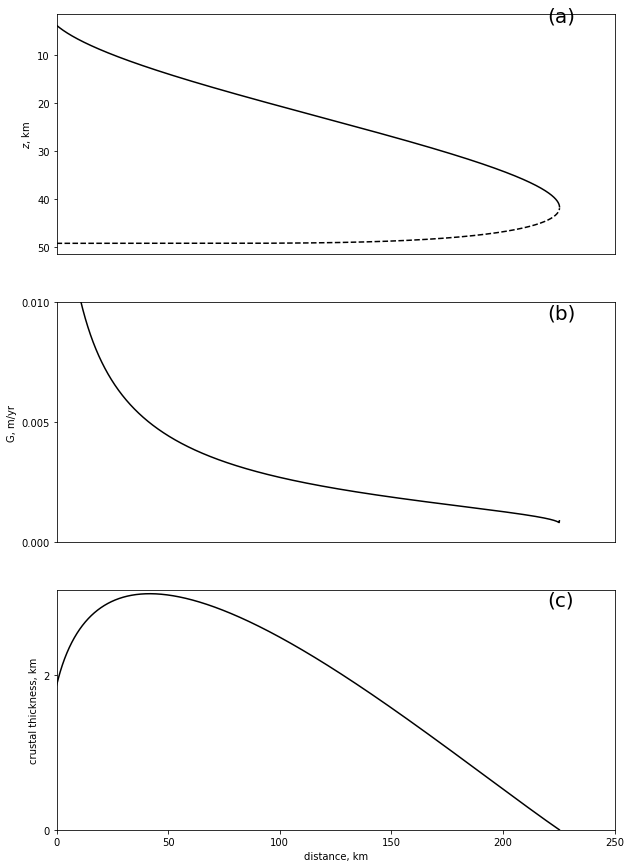

In [21]:
f, ax = plt.subplots(3, 1)
zoom = 1.0
f.set_size_inches(10.0 * zoom, 15.0 * zoom)
f.set_facecolor('w')

p = PAR()
dist = np.linspace(0, 500e3, 8000)
HH = np.asarray([melting_region_top_bottom(d, p) for d in dist])
h = HH[:, 0].flatten()
hb = HH[:, 1].flatten()
dhdx = np.gradient(h, dist)

p2 = PAR2()
M = melting_rate(dist, h, p2) * p2.fudge
dqdx, t1, t2 = Div_q(h, dhdx, hb, M, p2)

ifoc = np.argwhere(dqdx >= 0).flatten()
rfoc = np.arange(0, ifoc[-1]+1)
q = np.flip(cumtrapz(np.flip(dqdx[rfoc]), np.flip(dist[rfoc]), initial=0))

ax[0].plot(dist/1e3, h/1e3, 'k', dist/1e3, hb/1e3, '--k')
ax[0].set_ylabel(r'$z$, km')
ax[0].set_xticks(())
ax[0].set_xlim(0.0, 250.0)
#ax[0].set_yticks((0, 20, 40), (0, -20, -40))
ax[0].text(220.0, 3.0, r'(a)', fontsize=20)
ax[0].invert_yaxis()

ax[1].plot(dist/1e3, t2 * p2.secperyr, 'k')
ax[1].set_ylabel(r"G, m/yr")
ax[1].set_ylim(0.0, 0.01)
ax[1].set_xticks(())
ax[1].set_xlim(0.0, 250.0)
ax[1].set_yticks((0, 0.005, 0.01))
ax[1].text(220.0, 0.0093, r'(b)', fontsize=20)

ax[2].plot(dist[rfoc]/1e3, -q/p2.U0/1e3, 'k')
ax[2].set_ylabel('crustal thickness, km')
ax[2].set_ylim(0.0, 3.1)
ax[2].set_xlabel('distance, km')
ax[2].set_xticks((0, 50, 100, 150, 200, 250))
ax[2].set_xlim(0.0, 250.0)
ax[2].set_yticks((0.0, 2.0))
ax[2].text(220.0, 2.9, r'(c)', fontsize=20)

plt.show()